# Group Comparison
- Test differences between groups in PE and Amg-Hipp coupling

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# grab data
dfSCR = pd.read_csv('data/scr_clean2.csv') # PE and SCR data
dfROIs = pd.read_csv('data/neuroSynth_connectivity.csv') # brain data
dfGroups = pd.read_csv('data/demographic.csv') # load groups

In [5]:
df = pd.merge(pd.merge(dfSCR, dfROIs, left_on=['sub', 'Event.Nr'], right_on=['sub', 'trial']), dfGroups, left_on='sub', right_on='sub_id')

In [6]:
df

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,pe,scr,amg_hipp,amg_vmpfc,amg_SnM,amgM,trial,condition,sub_id,group,Gender,Age
0,sub-189,CSplusUS1,1,0.2852,0.801175,0.500000,0.2852,0.922353,0.880922,-0.178543,0.561003,1,CSplusUS1,sub-189,HC,2.0,26.0
1,sub-189,CSminus1,2,0.1033,0.796939,-0.500000,0.1033,0.131659,0.645556,0.078074,-0.021780,2,CSminus1,sub-189,HC,2.0,26.0
2,sub-189,CSplus1,3,0.0783,0.799047,-0.501304,0.0783,0.538454,0.690040,-0.027568,-0.055494,3,CSplus1,sub-189,HC,2.0,26.0
3,sub-189,CSplusUS1,4,0.1772,0.801165,0.500006,0.1772,0.751307,0.846971,0.085269,-0.190930,4,CSplusUS1,sub-189,HC,2.0,26.0
4,sub-189,CSminus1,5,0.0000,0.794832,-0.498696,0.0000,0.824036,0.681568,0.477865,0.028911,5,CSminus1,sub-189,HC,2.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,sub-152,CSplus2,65,0.0000,0.012591,-0.041406,0.0000,0.668299,0.648652,-0.180171,0.262373,65,CSplus2,sub-152,HC,2.0,24.0
4481,sub-152,CSminus2,66,0.0000,0.149719,-0.372661,0.0000,0.419242,0.506714,-0.190413,0.055292,66,CSminus2,sub-152,HC,2.0,24.0
4482,sub-152,CSminus2,67,0.0000,0.113651,-0.284416,0.0000,0.678883,0.308139,0.560303,0.146620,67,CSminus2,sub-152,HC,2.0,24.0
4483,sub-152,CSplus2,68,0.0000,0.011487,-0.038340,0.0000,0.805161,0.258436,0.571014,-0.179821,68,CSplus2,sub-152,HC,2.0,24.0


In [7]:
# build index for all Bayesian analysis
# Bayes model
# organize data
df['sub'] = df['sub'].astype('category')
#df['condition'] = df['condition'].astype('category')

n_sub = len(df['sub'].unique())
subIDX = df['sub'].cat.codes.values
# condition
n_cond = len(df['condition'].unique())
#condIDX = df['condition'].cat.codes.values
trials = df.trial.values - 1
amygdala = df.amgM.values


df['condition'].unique()

# generating condition index
df['cond'] = df['condition']#
df = df.replace(to_replace={'cond': {'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5}})

condIDX = df.cond.values

df['group'] = df['group'].astype('category')

groupIDX = df['group'].cat.codes.values
groupIDX

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [22]:
with pm.Model() as model_peG:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    #b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    mu_coup = pm.Normal('mu_coup', mu=0, sigma=.5)
    sigma_coup = pm.HalfCauchy('sigma_coup', .5)
    coup_matt = pm.Normal('coup_matt', mu=0, sd=1, shape=n_sub)
    b_coup = pm.Deterministic('b_coup', mu_coup + sigma_coup*coup_matt)
    
    # add group
    group = pm.Normal('grp', mu=0, sigma=.5, shape=3)
   
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + group[groupIDX] + b_trials*trials + b_amg*df.amgM + b_coup[subIDX]*df.amg_hipp)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace_peG = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, grp, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1002 seconds.


In [35]:
az.summary(trace_peG, var_names=['grp', 'mu_coup'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
grp[0],-0.027,0.277,-0.543,0.490,0.004,0.003,5257.0,5816.0,1.0
grp[1],-0.015,0.277,-0.520,0.515,0.004,0.003,5247.0,5581.0,1.0
grp[2],-0.006,0.277,-0.531,0.503,0.004,0.003,5254.0,5601.0,1.0
mu_coup,0.111,0.020,0.073,0.149,0.000,0.000,15136.0,6073.0,1.0


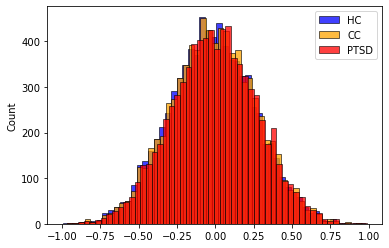

In [25]:
trStackedGpe = trace_peG.posterior.stack(draws=('chain','draw'))
trHC = trStackedGpe.grp[0,:].values
trCC = trStackedGpe.grp[1,:].values
trPTSD = trStackedGpe.grp[2,:].values
sns.histplot(trHC, label = 'HC', color = 'blue')
sns.histplot(trCC, label= 'CC', color = 'orange')
sns.histplot(trPTSD, label = 'PTSD', color = 'red')
plt.legend()

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-0.016,0.277,-0.541,0.534,0.004,0.003,5234.0,5569.0,NaN


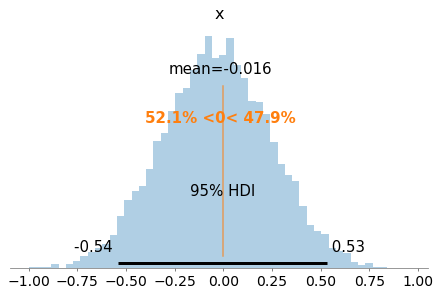

In [39]:
# mean effect for group
grp_total = np.mean(trStackedGpe.grp.values, axis=0)
az.plot_posterior(grp_total, hdi_prob=.95, kind='hist', ref_val=0)
az.summary(grp_total, hdi_prob=.95)

In [40]:
0.016/0.277

0.057761732851985555

<AxesSubplot:title={'center':'x'}>

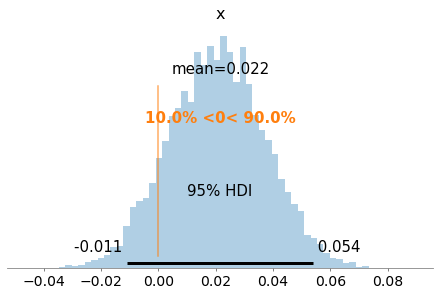

In [34]:
az.plot_posterior(trPTSD - trHC, hdi_prob=.95, kind='hist', ref_val=0)

<AxesSubplot:title={'center':'x'}>

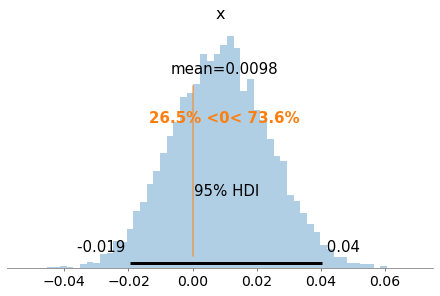

In [31]:
az.plot_posterior(trPTSD - trCC, hdi_prob=.95, kind='hist', ref_val=0)

<AxesSubplot:title={'center':'x'}>

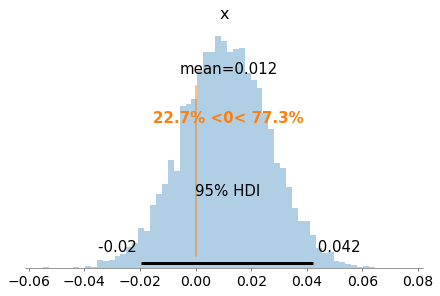

In [32]:
az.plot_posterior(trCC - trHC, hdi_prob=.95, kind='hist', ref_val=0)